# **Analisis Pengaruh Outlier terhadap Prediksi Usia Abalon Studi Komparatif: IQR dan Z-Score**

## Kelompok 3
Anggota Kelompok:
<ol>
  <li>Bintang Fikri Fauzan - 122140008</li>
  <li>Arkan Hariz C. Liem - 122140038</li>
  <li>Naufal Haris N. - 122140040</li>
  <li>Rahmat Aldi Nasda - 122140077</li>
  <li>Cici Tri Fadila.As - 122140086</li>
  <li>Dito Rifki Irawan - 122140153</li>
  <li>Ihya Razky Hidayat - 122140167</li>
</ol>

## 1. Import Library
<p>Langkah pertama dalam proyek ini adalah mengimpor berbagai library yang dibutuhkan, seperti <i>numpy, pandas, matplotlib, seaborn, scipy, dan scikit-learn.</i> Library ini digunakan untuk manipulasi data, visualisasi, preprocessing, serta membangun dan mengevaluasi model machine learning.</p>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy import stats

## 2. Load Dataset Abalone
<p>Dataset yang digunakan adalah Abalone Dataset dari UCI Machine Learning Repository. Dataset ini berisi informasi biologis mengenai abalon (sejenis kerang laut), dengan tujuan utama memprediksi usia abalon berdasarkan atribut fisik seperti panjang, diameter, berat, dan jenis kelamin.</p>
<p>Fitur target yang digunakan adalah Age, yang dihitung dari kolom Rings dengan penambahan 1.5, sesuai dengan dokumentasi dataset. Selain itu, fitur kategorikal Sex dikonversi menjadi variabel dummy melalui one-hot encoding, sehingga bisa digunakan oleh model regresi linier.</p>

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
column_names = ['Sex', 'Length', 'Diameter', 'Height', 'WholeWeight',
                'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Rings']
df = pd.read_csv(url, header=None, names=column_names)
df['Age'] = df['Rings'] + 1.5

# Encode kategori 'Sex'
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
df.drop('Rings', axis=1, inplace=True)

df.head()

,Length,Diameter,Height,WholeWeight,ShuckedWeight,VisceraWeight,ShellWeight,Age,Sex_I,Sex_M
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,16.5,False,True
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,8.5,False,True
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,10.5,False,False
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,11.5,False,True
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,8.5,True,False


## 3. Visualisasi Awal
<p>Distribusi awal dari usia abalon divisualisasikan menggunakan histogram dengan kurva KDE (Kernel Density Estimation). Tujuan dari visualisasi ini adalah untuk memahami pola penyebaran usia dan mendeteksi secara kasat mata apakah terdapat nilai-nilai yang mencurigakan atau outlier. Dari histogram, kita dapat melihat apakah distribusi cenderung normal, miring, atau memiliki ekor panjang yang mengindikasikan potensi pencilan.</p>

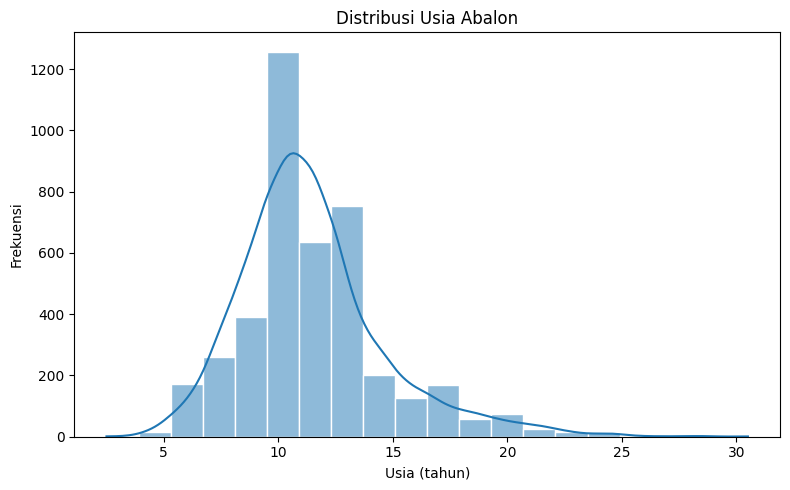

In [ ]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=df,
    x='Age',
    bins=20,
    kde=True,
    edgecolor='white'
)

plt.xlabel('Usia (tahun)')
plt.ylabel('Frekuensi')
plt.title('Distribusi Usia Abalon')
plt.tight_layout()
plt.show()

## 4. Fungsi Evaluasi Model
Sebelum melakukan eksperimen lebih lanjut, dibuat sebuah fungsi evaluate_model() untuk mengukur performa model regresi linier. Fungsi ini membagi data menjadi data latih dan uji (dengan proporsi 80:20), melatih model <i>Linear Regression</i>, dan menghitung dua metrik utama:

RMSE (Root Mean Squared Error): Mengukur rata-rata error prediksi dalam satuan yang sama dengan target.

R² Score: Mengukur seberapa besar variasi pada variabel target dapat dijelaskan oleh model. Nilai 1 menandakan prediksi sempurna, sedangkan nilai di bawah 0 menunjukkan model lebih buruk dari rata-rata.

Fungsi ini dipakai secara konsisten di semua tahap evaluasi, sehingga hasil antar-metode bisa dibandingkan secara adil.

In [ ]:
def evaluate_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    return rmse, r2


## 5. Evaluasi Model (Data Asli)
Langkah ini bertujuan untuk mendapatkan baseline atau acuan performa model sebelum dilakukan penanganan outlier. Data asli yang belum dibersihkan digunakan untuk melatih dan menguji model. Hasil evaluasi ini sangat penting karena akan menjadi pembanding ketika kita mulai menghapus outlier dengan dua metode berbeda.

In [ ]:
X = df.drop('Age', axis=1)
y = df['Age']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
rmse_original, r2_original = evaluate_model(X_scaled, y)

## 6. Deteksi dan Hapus Outlier
Penelitian ini berfokus pada dua metode deteksi outlier: Z-Score dan Interquartile Range (IQR).

a. Z-Score<br>
Z-Score mengukur seberapa jauh nilai suatu data dari rata-rata dalam satuan standar deviasi. Jika nilai Z-Score lebih dari 2.5 atau kurang dari -2.5, data dianggap outlier. Pendekatan ini cocok untuk data yang terdistribusi tidak normal (esktrim). Dalam notebook ini, hanya data dengan Z-Score < 2.5 di seluruh fitur numerik yang disimpan.

b. Interquartile Range (IQR)<br>
Metode IQR lebih robust terhadap distribusi yang tidak normal. IQR dihitung dari selisih kuartil ketiga (Q3) dan kuartil pertama (Q1). Data dianggap outlier jika berada di bawah Q1 - 1.5×IQR atau di atas Q3 + 1.5×IQR. Filtering dilakukan secara baris per baris: jika sebuah baris memiliki setidaknya satu nilai numerik yang ekstrem, maka seluruh baris dihapus.

In [ ]:
results = {}
sample_sizes = {}

# --- Z-Score ---
z_scores = np.abs(stats.zscore(df.select_dtypes(include=[np.number])))
filtered_z = df[(z_scores < 2.5).all(axis=1)]
X_z = filtered_z.drop('Age', axis=1)
y_z = filtered_z['Age']
X_z_scaled = scaler.fit_transform(X_z)
results['Z-Score'] = evaluate_model(X_z_scaled, y_z)
sample_sizes['Z-Score'] = len(filtered_z)

# --- IQR ---
df_num = df.select_dtypes(include=[np.number])
Q1 = df_num.quantile(0.25)
Q3 = df_num.quantile(0.75)
IQR = Q3 - Q1
filtered_iqr = df[~((df_num < (Q1 - 1.5 * IQR)) | (df_num > (Q3 + 1.5 * IQR))).any(axis=1)]
X_iqr = filtered_iqr.drop('Age', axis=1)
y_iqr = filtered_iqr['Age']
X_iqr_scaled = scaler.fit_transform(X_iqr)
results['IQR'] = evaluate_model(X_iqr_scaled, y_iqr)
sample_sizes['IQR'] = len(filtered_iqr)

## 7. Hasil Evaluasi
Setelah membersihkan data dari outlier, model regresi linier kembali dilatih dan diuji pada masing-masing versi data (Z-Score dan IQR). Proses evaluasi tetap sama seperti sebelumnya, menggunakan RMSE dan R² Score, sehingga perubahan performa model dapat dianalisis secara langsung. Ini memungkinkan kita untuk menilai apakah pembersihan outlier memberikan dampak positif terhadap akurasi prediksi.

In [ ]:
# Print Evaluasi hasil
print("Hasil Evaluasi Model:")
print(f"Original: RMSE = {rmse_original:.2f}, R2 = {r2_original:.2f}, Sample Size = {len(df)}")
print(f"Z-Score: RMSE = {results['Z-Score'][0]:.2f}, R2 = {results['Z-Score'][1]:.2f}, Sample Size = {sample_sizes['Z-Score']}")
print(f"IQR: RMSE = {results['IQR'][0]:.2f}, R2 = {results['IQR'][1]:.2f}, Sample Size = {sample_sizes['IQR']}")

print("\nPerbandingan Ukuran Sampel:")
print(f"Original: {len(df)}")
print(f"Z-Score: {sample_sizes['Z-Score']}")
print(f"IQR: {sample_sizes['IQR']}")

print("\nPerbandingan RMSE:")
print(f"Original: {rmse_original:.2f}")
print(f"Z-Score: {results['Z-Score'][0]:.2f}")
print(f"IQR: {results['IQR'][0]:.2f}")

print("\nPerbandingan R2:")
print(f"Original: {r2_original:.2f}")
print(f"Z-Score: {results['Z-Score'][1]:.2f}")
print(f"IQR: {results['IQR'][1]:.2f}")

Hasil Evaluasi Model:
Original: RMSE = 2.21, R2 = 0.55, Sample Size = 4177
Z-Score: RMSE = 1.87, R2 = 0.49, Sample Size = 3849
IQR: RMSE = 1.62, R2 = 0.53, Sample Size = 3781

Perbandingan Ukuran Sampel:
Original: 4177
Z-Score: 3849
IQR: 3781

Perbandingan RMSE:
Original: 2.21
Z-Score: 1.87
IQR: 1.62

Perbandingan R2:
Original: 0.55
Z-Score: 0.49
IQR: 0.53


## 8. Visualisasi Perbandingan
<p>Hasil evaluasi disajikan dalam bentuk grafik batang (bar chart) yang membandingkan:
<li>Nilai RMSE dari ketiga kondisi: original, Z-Score, dan IQR</li>
<li>Nilai R² Score</li>
<li>Jumlah sampel yang tersisa setelah masing-masing metode pembersihan diterapkan</li>

Visualisasi ini memudahkan pembaca untuk melihat trade-off antara peningkatan akurasi dengan kehilangan data akibat penghapusan outlier.</p>

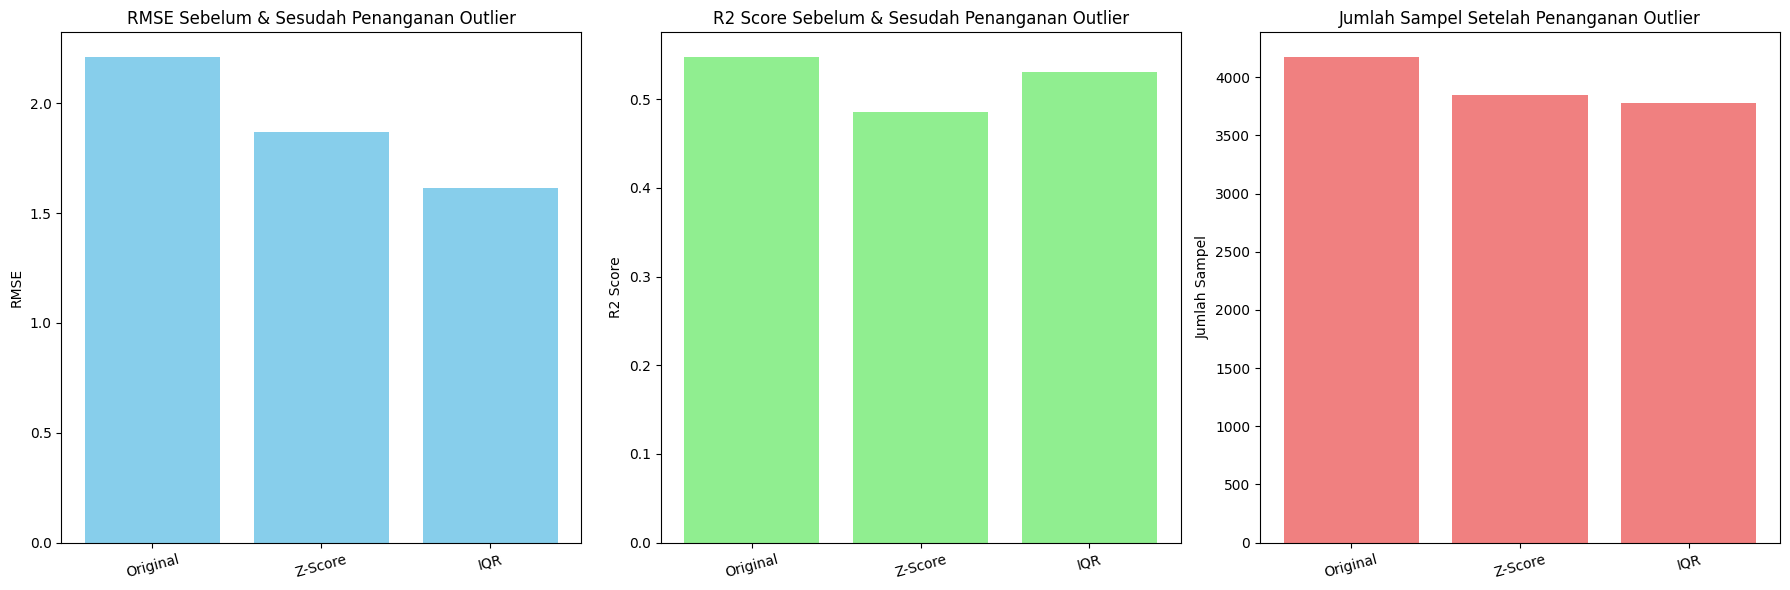

In [ ]:
labels = ['Original', 'Z-Score', 'IQR']
rmse_scores = [rmse_original] + [results[m][0] for m in results]
r2_scores = [r2_original] + [results[m][1] for m in results]
sizes = [len(df)] + [sample_sizes[m] for m in results]

fig, axs = plt.subplots(1, 3, figsize=(18, 6))

axs[0].bar(labels, rmse_scores, color='skyblue')
axs[0].set_title('RMSE Sebelum & Sesudah Penanganan Outlier')
axs[0].set_ylabel('RMSE')
axs[0].set_xticks(range(len(labels)))
axs[0].set_xticklabels(labels, rotation=15)

axs[1].bar(labels, r2_scores, color='lightgreen')
axs[1].set_title('R2 Score Sebelum & Sesudah Penanganan Outlier')
axs[1].set_ylabel('R2 Score')
axs[1].set_xticks(range(len(labels)))
axs[1].set_xticklabels(labels, rotation=15)

axs[2].bar(labels, sizes, color='lightcoral')
axs[2].set_title('Jumlah Sampel Setelah Penanganan Outlier')
axs[2].set_ylabel('Jumlah Sampel')
axs[2].set_xticks(range(len(labels)))
axs[2].set_xticklabels(labels, rotation=15)

plt.tight_layout()
plt.show()

## Visualisasi Menggunakan Scatterplot

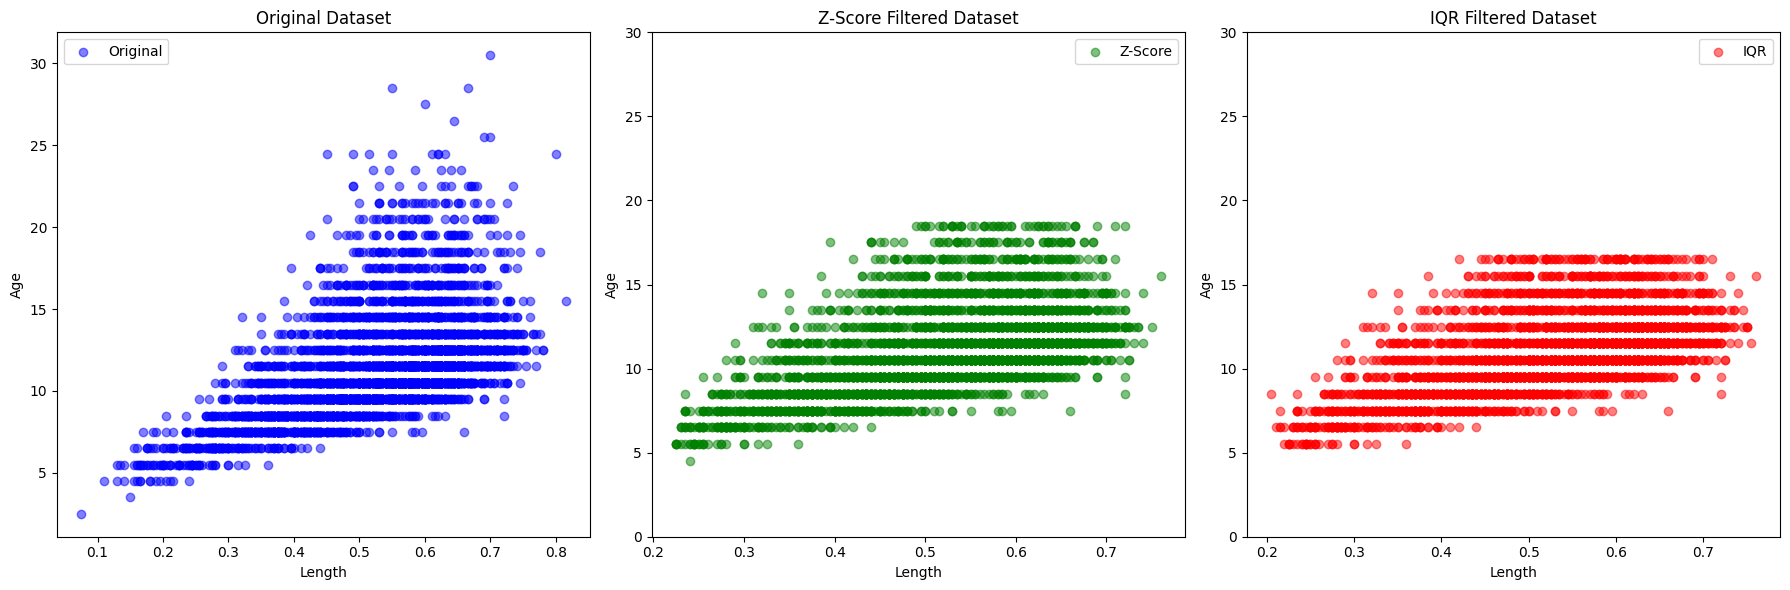

In [ ]:
plt.figure(figsize=(18, 6))

# Scatterplot untuk data asli
plt.subplot(1, 3, 1)
plt.scatter(df['Length'], df['Age'], alpha=0.5, label='Original', color='blue')
plt.title('Original Dataset')
plt.xlabel('Length')
plt.ylabel('Age')
plt.legend()

# Scatterplot untuk data setelah penanganan outlier dengan Z-Score
plt.subplot(1, 3, 2)
plt.scatter(filtered_z['Length'], filtered_z['Age'], alpha=0.5, label='Z-Score', color='green')
plt.title('Z-Score Filtered Dataset')
plt.xlabel('Length')
plt.ylabel('Age')
plt.ylim(0, 30)  # Batasi sumbu y untuk perbandingan yang lebih baik
plt.legend()

# Scatterplot untuk data setelah penanganan outlier dengan IQR
plt.subplot(1, 3, 3)
plt.scatter(filtered_iqr['Length'], filtered_iqr['Age'], alpha=0.5, label='IQR', color='red')
plt.title('IQR Filtered Dataset')
plt.xlabel('Length')
plt.ylabel('Age')
plt.ylim(0, 30)  # Batasi sumbu y untuk perbandingan yang lebih baik
plt.legend()

plt.tight_layout()
plt.show()

## Visualisasi Perbandingan antar Fitur

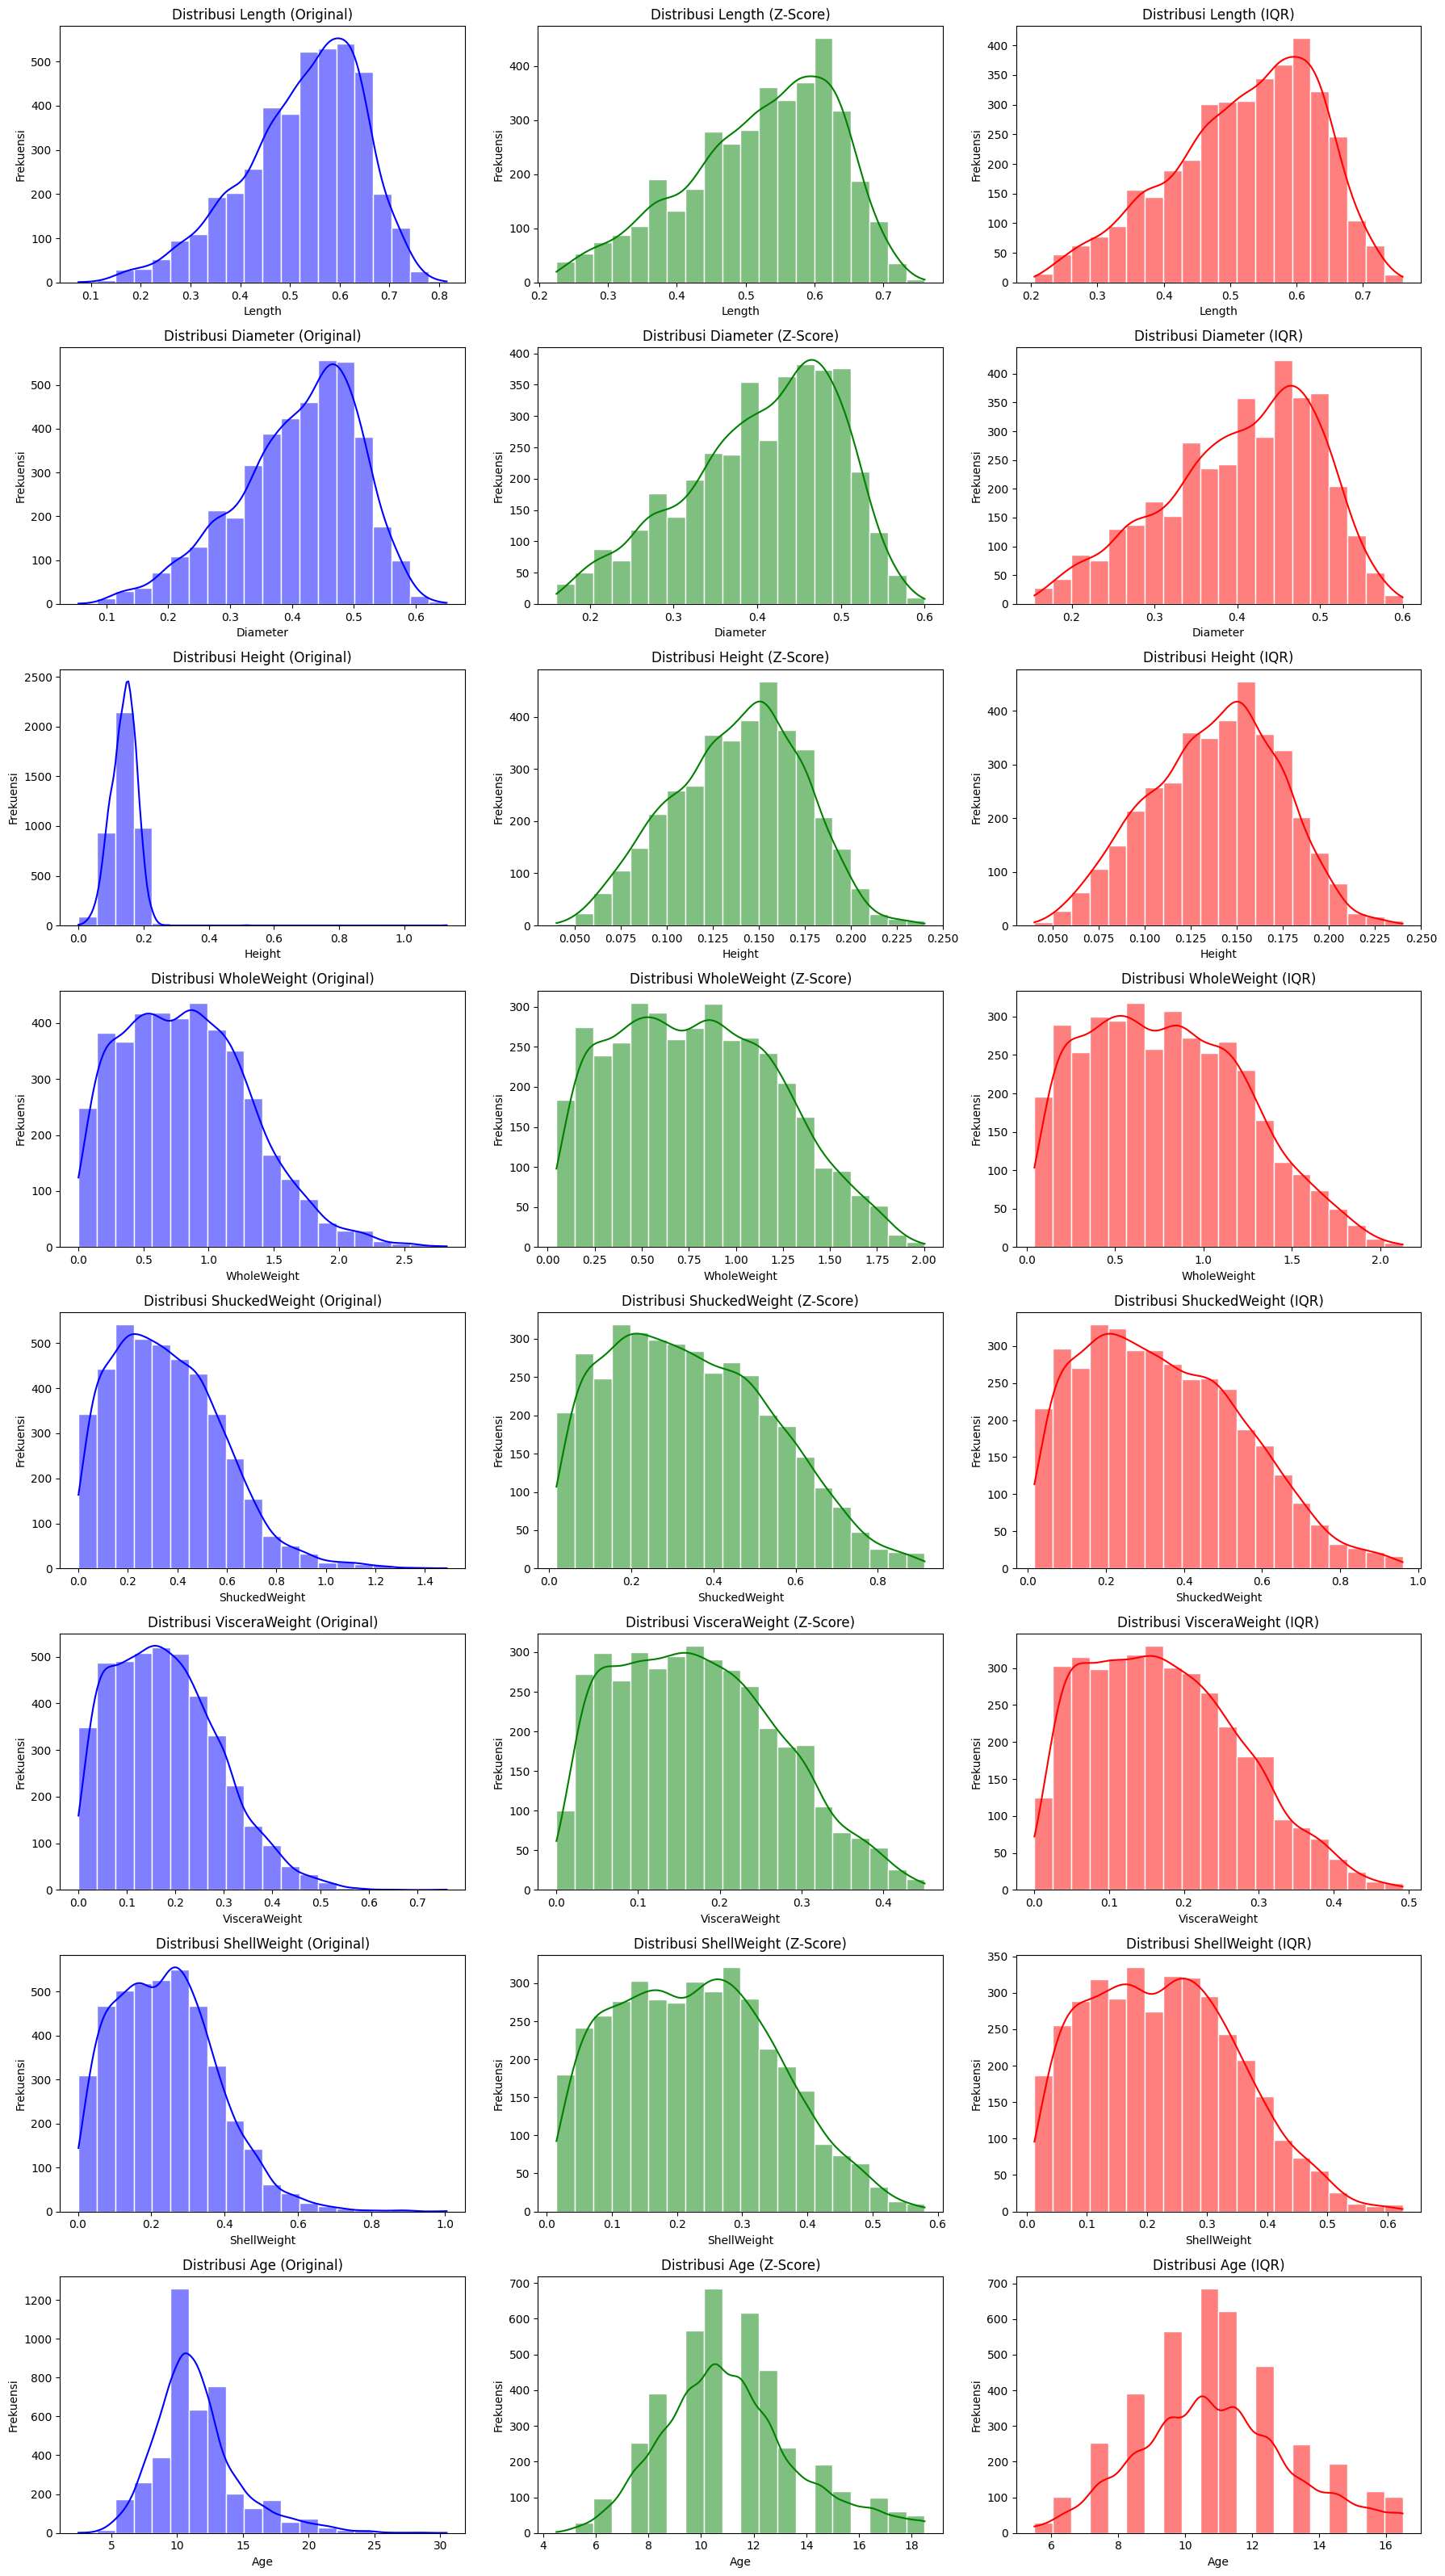

In [ ]:
features = ['Length', 'Diameter', 'Height', 'WholeWeight', 'ShuckedWeight', 'VisceraWeight', 'ShellWeight', 'Age']
fig, axs = plt.subplots(len(features), 3, figsize=(18, len(features) * 4))

for i, feature in enumerate(features):
    # Distribusi data asli
    sns.histplot(df[feature], bins=20, kde=True, ax=axs[i, 0], color='blue', edgecolor='white')
    axs[i, 0].set_title(f'Distribusi {feature} (Original)')
    axs[i, 0].set_xlabel(feature)
    axs[i, 0].set_ylabel('Frekuensi')

    # Distribusi data setelah penanganan outlier dengan Z-Score
    sns.histplot(filtered_z[feature], bins=20, kde=True, ax=axs[i, 1], color='green', edgecolor='white')
    axs[i, 1].set_title(f'Distribusi {feature} (Z-Score)')
    axs[i, 1].set_xlabel(feature)
    axs[i, 1].set_ylabel('Frekuensi')

    # Distribusi data setelah penanganan outlier dengan IQR
    sns.histplot(filtered_iqr[feature], bins=20, kde=True, ax=axs[i, 2], color='red', edgecolor='white')
    axs[i, 2].set_title(f'Distribusi {feature} (IQR)')
    axs[i, 2].set_xlabel(feature)
    axs[i, 2].set_ylabel('Frekuensi')

plt.tight_layout()
plt.show()

## 9. Analisis Hasil

### **Metode yang Dibandingkan**
1. **Original Dataset** (Baseline)
2. **Z-Score** (±2.5 SD)
3. **IQR** (1.5 × IQR)

---

### **Hasil Evaluasi**

### **1. Perbandingan Ukuran Sampel**
| Metode   | Jumlah Sampel | Data Dihapus | % Data Dihapus |
|----------|--------------|--------------|----------------|
| Original | 4177         | -            | -              |
| Z-Score  | 3849         | 328          | 7.8%           |
| IQR      | 3781         | 396          | 9.5%           |

**Insight**:
- IQR lebih agresif menghapus outlier dibanding Z-Score.
- Jika data tidak berdistribusi normal, Z-Score mungkin kurang efektif.

---

### **2. Perbandingan Kinerja Model**
| Metode   | RMSE  | Δ RMSE (vs Original) | R²   | Δ R² (vs Original) |
|----------|-------|----------------------|------|--------------------|
| Original | 2.21  | -                    | 0.55 | -                  |
| Z-Score  | 1.87  | **↓ 15.4%**          | 0.49 | ↓ 0.06             |
| IQR      | 1.62  | **↓ 26.7%**          | 0.53 | ↓ 0.02             |

**Insight**:
- **IQR memberikan penurunan RMSE terbesar (26.7%)**, menunjukkan peningkatan akurasi prediksi.
- **R² relatif stabil**, meskipun sedikit turun (trade-off yang wajar).
- Z-Score kurang konsisten: RMSE membaik, tetapi R² turun lebih banyak dibanding IQR.

---

### **Kesimpulan**
1. **IQR lebih unggul** dalam menangani outlier untuk dataset ini:
   - Menghasilkan **RMSE terendah (1.62)** dengan **penghapusan data moderat**.
   - Cocok untuk data yang **tidak berdistribusi normal** atau memiliki **outlier kuat**.
2. **Z-Score kurang optimal**:
   - Mungkin karena data tidak memenuhi asumsi normalitas.
   - Lebih sedikit menghapus outlier, sehingga dampaknya kecil.

---

**Catatan**:  
- Penurunan R² tidak signifikan, tetapi jika model digunakan untuk inferensi, perlu evaluasi lebih lanjut.
- IQR adalah pilihan terbaik untuk kasus ini berdasarkan metrik RMSE.